# Animal Image Classification

**Author:** Davyd Antoniuk 

**Project Goal:** Build and compare machine learning/deep learning models (Random Forest, XGBoost, CNN, advanced CNN, and Transfer Learning) to classify images of animals into 10 categories.

## 1. Introduction

This project explores different architectures, from simple CNNs to pre-trained models, analyzing their performance on the [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10) dataset. The goal is to find the best model in terms of accuracy, efficiency, and generalization.

## 2. Data Preparation & Exploration

In [ ]:
import os
import shutil
import random
import time
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import copy

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from PIL import Image

### 2.1 Dataset overview

The Animals-10 dataset contains images of 10 animal classes: `dog`, `cat`, `horse`, `spider`, `butterfly`, `chicken`, `cow`, `sheep`, `squirrel`, `elephant`. The dataset is organized into folders, but the class names are in Italian language. I will translate them to English for clarity before processing.

Now, let's load and explore the dataset!

### 2.2 Load and Preprocess Dataset

**Step 1:** Define Paths and Translations

*Set the dataset path and create a dictionary to rename folders from Italian to English.*

In [2]:
# Original dataset path
data_path = "data"

# Translation dictionary (Italian → English)
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "scoiattolo": "squirrel", "ragno": "spider"
}

**Step 2:** Rename Folders to English

*Rename all class folders using the translation dictionary.*

In [3]:
for folder in os.listdir(data_path):
    if folder in translate:
        old_folder = os.path.join(data_path, folder)
        new_folder = os.path.join(data_path, translate[folder])
        os.rename(old_folder, new_folder)

print("Folders renamed successfully!")

Folders renamed successfully!


**Step 3:** Count Images per Class

*Count and visualize how many images each class has*

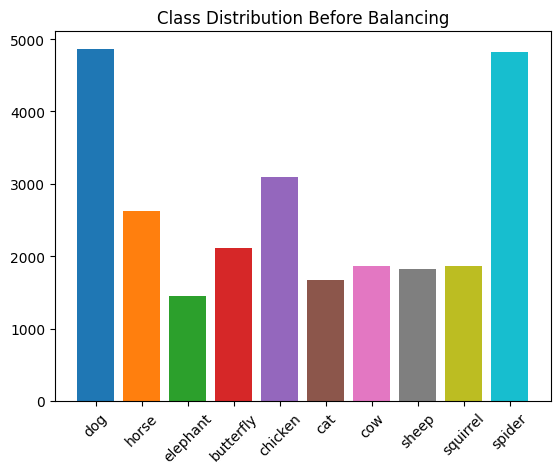

In [13]:
class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in translate.values()}
colors = plt.cm.tab10(range(len(class_counts)))
# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xticks(rotation=45)
plt.title("Class Distribution Before Balancing")
plt.show()

The dataset is imbalanced - **dogs** and **spiders** have the most images, while **elephants** have the least. However, this isn’t a problem because I will reduce each class to *200 images* to ensure fair training and manage computational resources efficiently.

**Step 4:** Balance the Dataset 

*Reduce each class to 200 images to manage computational resources.*

In [ ]:
target_count = 200

for cls in translate.values():
    class_path = os.path.join(data_path, cls)
    images = os.listdir(class_path)
    
    # Keep only the first 200 images
    for img in images[target_count:]:
        os.remove(os.path.join(class_path, img))

print("Dataset balanced: Each class now has 200 images.")

Dataset balanced: Each class now has 200 images.


**Step 6:** Verify New Distribution

*Confirm that each class now contains 200 images.*

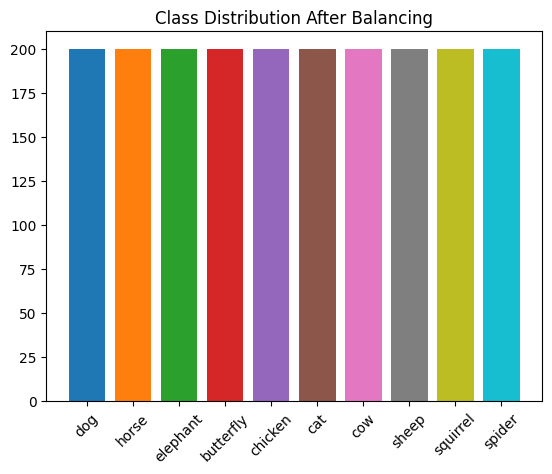

In [16]:
new_class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in translate.values()}

colors = plt.cm.tab10(range(len(new_class_counts)))
plt.bar(new_class_counts.keys(), new_class_counts.values(), color=colors)
plt.xticks(rotation=45)
plt.title("Class Distribution After Balancing")
plt.show()

Now every class has the same number of images, and I can move on to the next stage

### 2.3 Detailed Dataset Exploration

**Step 1:** Define the Visualization Function

Now, let's visualize random images from the dataset to better understand the data distribution and quality. Below is a function to display a grid of random images with their corresponding class labels. The function allows specifying the number of images to visualize dynamically.

In [18]:
def visualize_random_images(folder, num_images=9):
    """
    Displays a grid of random images from the dataset.
    
    Args:
        folder (str): Path to the dataset folder.
        num_images (int): Number of images to visualize.
    """
    # Get all class names (folders)
    class_names = os.listdir(folder)
    
    # Collect random images with labels
    images = []
    labels = []
    
    for _ in range(num_images):
        selected_class = random.choice(class_names)  # Choose a random class
        class_path = os.path.join(folder, selected_class)
        image_name = random.choice(os.listdir(class_path))  # Choose a random image
        image_path = os.path.join(class_path, image_name)
        
        # Read and store the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        images.append(img)
        labels.append(selected_class)

    # Determine the grid size dynamically
    grid_size = int(num_images ** 0.5)  # Find the closest square root
    while grid_size * grid_size < num_images:
        grid_size += 1  # Adjust for non-perfect squares

    # Set figure size dynamically
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    fig.suptitle("Random Sample Images", fontsize=14)

    # Flatten axes for easy iteration (handles cases where grid isn't perfect)
    axes = axes.flatten()

    for i in range(grid_size * grid_size):
        if i < num_images:
            axes[i].imshow(images[i])
            axes[i].set_title(labels[i])
        axes[i].axis('off')  # Hide axes

    plt.show()

**Step 2:** Visualize Random Images

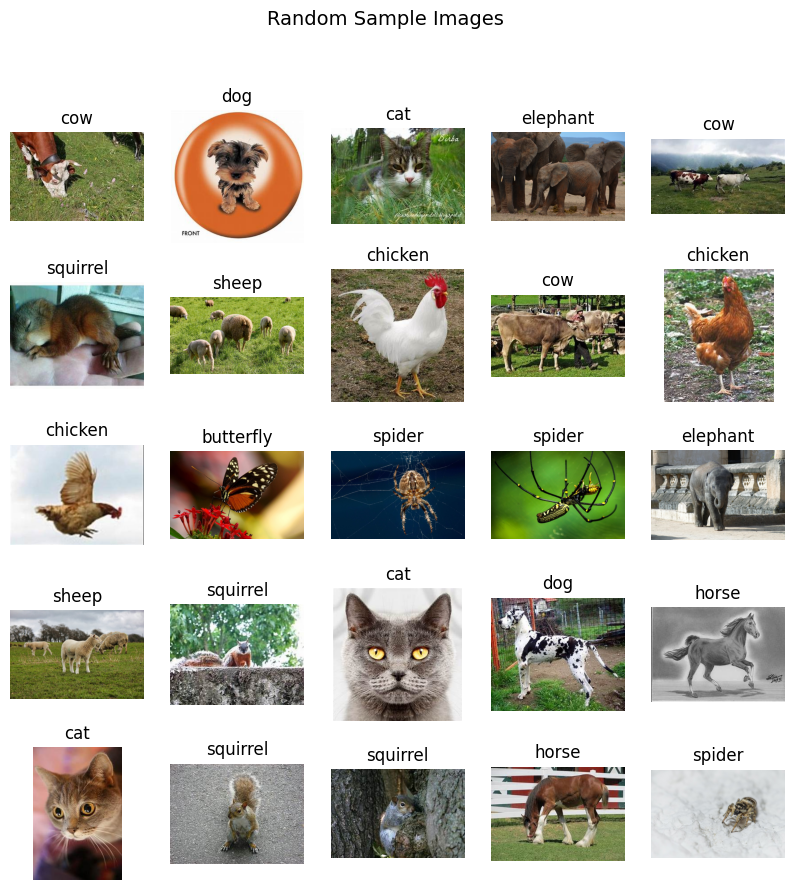

In [22]:
visualize_random_images("data", num_images=25)

The images are **well-labeled** and **clearly represent** their respective classes. The dataset quality looks good for training, so we can proceed to the next step: **image preprocessing**.

### 2.4 Train-Validation-Test Split

I will split the dataset into Train (70%), Validation (15%), and Test (15%), ensuring each class has exactly 200 images.



**Step 1:** Define Paths and Create Split Folders

*Create separate folders for train, validation, and test sets.*

In [24]:
# Define paths
dataset_path = "data"
split_path = "split_data"

# Create train, val, and test directories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(split_path, split), exist_ok=True)

**Step 2:** Perform Train-Validation-Test Split

*Split images and copy them into new structured folders.*

In [25]:
split_ratio = {"train": 0.7, "val": 0.15, "test": 0.15}

for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    
    # Shuffle and split images
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratio["train"]), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=split_ratio["test"] / (split_ratio["val"] + split_ratio["test"]), random_state=42)
    
    # Copy images to respective folders
    for split, img_list in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_class_path = os.path.join(split_path, split, cls)
        os.makedirs(split_class_path, exist_ok=True)
        
        for img in img_list:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(split_class_path, img)
            shutil.copy(src_path, dst_path)

print("Dataset successfully split into Train, Validation, and Test sets!")

Dataset successfully split into Train, Validation, and Test sets!


**Step 3:** Visualize Class Distribution After Splitting

*Plot the number of images per class for Train, Validation, and Test sets.*

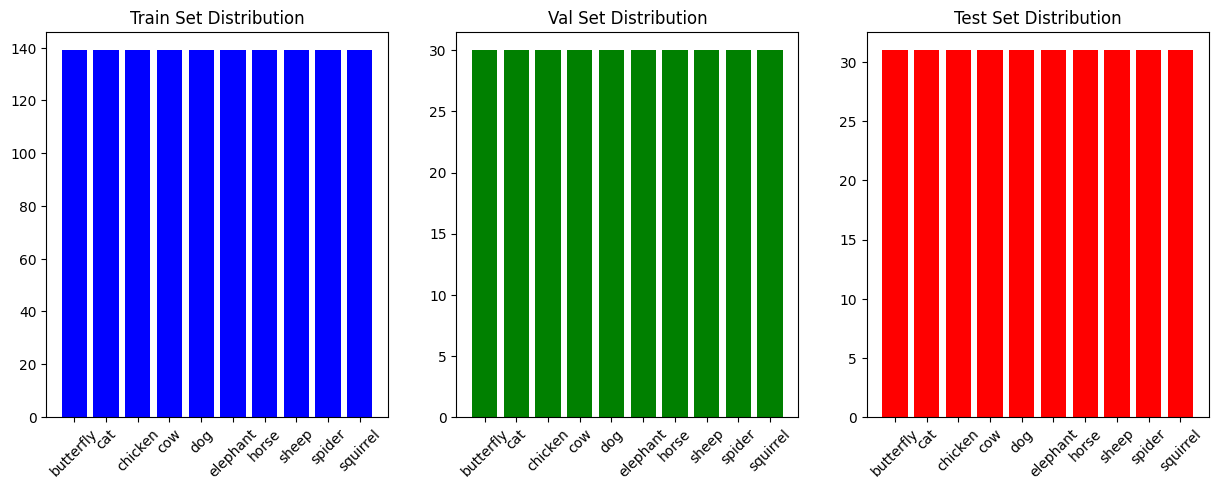

In [30]:
# Count images in each split
split_counts = {"train": {}, "val": {}, "test": {}}

for split in ["train", "val", "test"]:
    for cls in os.listdir(os.path.join(split_path, split)):
        split_counts[split][cls] = len(os.listdir(os.path.join(split_path, split, cls)))

# Define colors for each split
colors = {"train": "blue", "val": "green", "test": "red"}

# Plot class distribution per split
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
splits = ["train", "val", "test"]

for i, split in enumerate(splits):
    axes[i].bar(split_counts[split].keys(), split_counts[split].values(), color=colors[split])
    axes[i].set_title(f"{split.capitalize()} Set Distribution")
    axes[i].set_xticks(range(len(split_counts[split].keys())))
    axes[i].set_xticklabels(split_counts[split].keys(), rotation=45)

plt.show()

Each set has the same number of images per class.

The dataset is successfully split, and each class has the correct number of images. Now, we can move to image preprocessing!

### 2.5 Image Preprocessing

Now, I will **prepare the images for model training** by applying **augmentation**, **normalization**, and **resizing** while ensuring different models receive the correct preprocessing.

Since different models require different preprocessing, I will create two versions of the dataset:
- Standardized dataset → For **Random Forest**, **XGBoost**, **CNN**
- Lightly Processed dataset → For Transfer Learning models (ResNet, VGG, EfficientNet, etc.)

#### 2.5.1 Define Image Transformations

1. **Apply Data Augmentation (Only for Training Set)**\
As discussed [here](https://datascience.stackexchange.com/questions/86356/first-perform-data-augmentation-or-normalization), augmentation must be applied before normalization to avoid distorting pixel distributions.

2. **Apply Normalization (For RF, XGBoost, CNN)**\
As discussed [here](https://datascience.stackexchange.com/questions/94537/normalization-vs-standardization-for-image-classification-problem), normalization works better than standardization for deep learning models since it helps capture relations inside images more effectively.

*Applied augmentation (for training only) and normalization where needed.*

In [100]:
IMAGE_SIZE = (224, 224)

# Augmentation + Normalization (For CNN, RF, XGBoost)
standardized_train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip image with 50% chance
    transforms.RandomRotation(15),  # Rotate randomly by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust colors
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # Random zoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])

# Only Normalization (Validation & Test - No Augmentation)
standardized_test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])

#  Only Resize (For Transfer Learning Models)
transfer_learning_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # No normalization, as pre-trained models handle it
])

#### 2.5.2 Load the Dataset


*Loaded datasets with the correct preprocessing for each model type.*

In [101]:
# Paths to datasets
train_path = "split_data/train"
val_path = "split_data/val"
test_path = "split_data/test"

# Load datasets with respective transformations
standardized_train_dataset = datasets.ImageFolder(root=train_path, transform=standardized_train_transforms)
standardized_val_dataset = datasets.ImageFolder(root=val_path, transform=standardized_test_transforms)
standardized_test_dataset = datasets.ImageFolder(root=test_path, transform=standardized_test_transforms)

transfer_train_dataset = datasets.ImageFolder(root=train_path, transform=transfer_learning_transforms)
transfer_val_dataset = datasets.ImageFolder(root=val_path, transform=transfer_learning_transforms)
transfer_test_dataset = datasets.ImageFolder(root=test_path, transform=transfer_learning_transforms)

print("Datasets successfully loaded with augmentation and transformations!")

Datasets successfully loaded with augmentation and transformations!


#### 2.5.3 Create Data Loaders

*Created efficient batch loaders for each dataset version.*

In [102]:
BATCH_SIZE = 32

# Standardized dataset loaders (For CNN, RF, XGBoost)
standardized_train_loader = DataLoader(standardized_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
standardized_val_loader = DataLoader(standardized_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
standardized_test_loader = DataLoader(standardized_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Transfer Learning dataset loaders
transfer_train_loader = DataLoader(transfer_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
transfer_val_loader = DataLoader(transfer_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
transfer_test_loader = DataLoader(transfer_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


#### 2.5.4 Verify Preprocessing (Visualization at Each Step)

To understand better how work image preprocessing, I will visualize a random images before and after applying augmentation and normalization.

**Function to Visualize Original Images (Before Processing)**

In [103]:
def show_original_images(folder, num_images=5):
    """ Display original images from dataset """
    class_names = os.listdir(folder)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        selected_class = random.choice(class_names)
        class_path = os.path.join(folder, selected_class)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        axes[i].imshow(img)
        axes[i].set_title(selected_class)
        axes[i].axis("off")

    plt.show()

**Function to Visualize Images After Augmentation & Normalization**

In [104]:
def show_augmented_images(dataloader, title):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    for i in range(5):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to image format
        img = (img * 0.5) + 0.5  # Unnormalize for visualization
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {labels[i].item()}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

As, I build functions to visualize images at each step of the preprocessing pipeline, now I will visualize a random image at each step to understand how the preprocessing works.

*Displays original images before any transformations.*

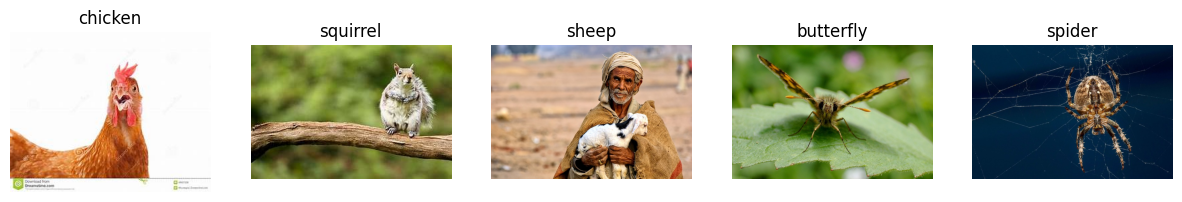

In [53]:
show_original_images("split_data/train", num_images=5)

*Shows images after augmentation & normalization.*

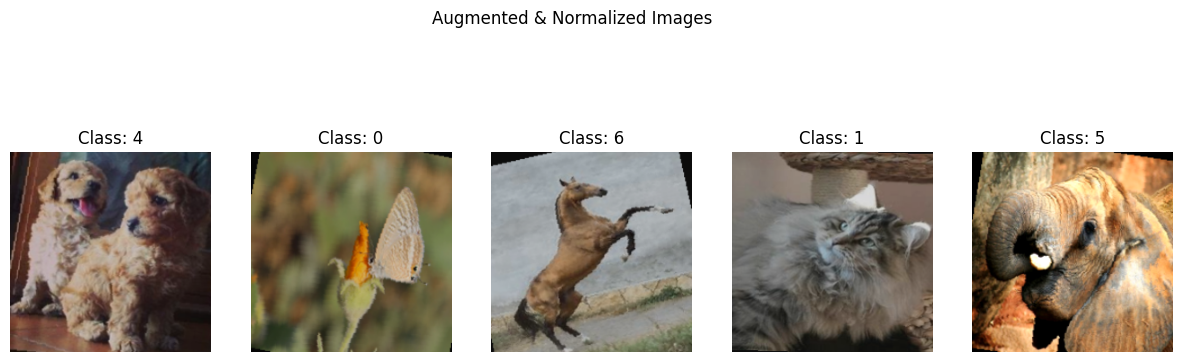

In [54]:
show_augmented_images(standardized_train_loader, "Augmented & Normalized Images")

**Next Step: Model Building!**

Now, I can start training models:

1. Random Forest, XGBoost
2. Simple CNN Model
3. Deeper CNN Model
4. Transfer Learning (ResNet, VGG, EfficientNet, etc.)

## 3. Model Building

### 3.1 Model Evaluation Function

Before training models, I need a function to calculate and return all evaluation metrics, including **Accuracy**, **Precision**, **Recall**, **F1-Score**, and the **Confusion Matrix**.

**Define the Evaluation Function**

*Computes Accuracy, Precision, Recall, F1-score, and Confusion Matrix.*

In [56]:
def evaluate_model(model, dataloader, dataset, device):
    """
    Evaluates the model and returns accuracy, precision, recall, F1-score, and confusion matrix.
    
    Args:
        model: Trained model to evaluate.
        dataloader: DataLoader for test/validation dataset.
        dataset: Corresponding dataset to map class indices to labels.
        device: Device (CPU/GPU) for evaluation.
        
    Returns:
        metrics_dict: Dictionary with all evaluation metrics.
        conf_matrix: Confusion matrix (optional for visualization).
    """
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():  # No gradients needed during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate Accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate Precision, Recall, and F1-score (macro-averaged)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro", zero_division=0)

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Store metrics in a dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

    return metrics_dict, conf_matrix

**Function to Display Confusion Matrix**

*Generates a heatmap of the confusion matrix for better analysis.*

In [64]:
def plot_confusion_matrix(conf_matrix, dataset):
    """Plots the confusion matrix."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### 3.2 Random Forest Model

Now, I will train **Random Forest**, which requires **feature extraction** since it cannot directly process images.

**Step 1:** Extract Features Using Pre-trained CNN (ResNet-18)

*Uses ResNet-18 to extract image features before training Random Forest.*

In [60]:
def extract_features(dataloader, model, device):
    """
    Extracts image features using a pre-trained CNN (ResNet-18).
    
    Args:
        dataloader: DataLoader containing images.
        model: Pre-trained CNN model.
        device: CPU or GPU.
    
    Returns:
        features: Extracted feature vectors.
        labels: Corresponding labels.
    """
    model.eval()  # Set to evaluation mode
    all_features, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = model(images)  # Extract features
            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.vstack(all_features), np.array(all_labels)

# Load Pre-trained ResNet18 (Removing Fully Connected Layer)
feature_extractor = resnet18(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(feature_extractor.children())[:-1])  # Remove last FC layer
feature_extractor.to("cuda" if torch.cuda.is_available() else "cpu")

# Extract Features
train_features, train_labels = extract_features(standardized_train_loader, feature_extractor, "cuda")
test_features, test_labels = extract_features(standardized_test_loader, feature_extractor, "cuda")

**Step 2:** Train Random Forest

*Trains Random Forest using extracted image features and records training time.*

In [61]:
# Train RF and measure time
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_model.fit(train_features.reshape(train_features.shape[0], -1), train_labels)
training_time = time.time() - start_time

print(f"Random Forest Training Time: {training_time:.2f} seconds")

Random Forest Training Time: 1.70 seconds


**Step 3:** Evaluate Random Forest

*Evaluates RF using extracted features and stores the results.*

In [62]:
# Make Predictions
rf_preds = rf_model.predict(test_features.reshape(test_features.shape[0], -1))

# Compute Metrics
accuracy = accuracy_score(test_labels, rf_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, rf_preds, average="macro", zero_division=0)
conf_matrix = confusion_matrix(test_labels, rf_preds)

# Store Results
rf_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Training Time (s)": training_time
}

print("Random Forest Evaluation Metrics:")
print(rf_metrics)

Random Forest Evaluation Metrics:
{'Accuracy': 0.9354838709677419, 'Precision': 0.9381661349403284, 'Recall': 0.9354838709677418, 'F1-Score': 0.9349129843719057, 'Training Time (s)': 1.6964747905731201}


*Displays confusion matrix for Random Forest.*

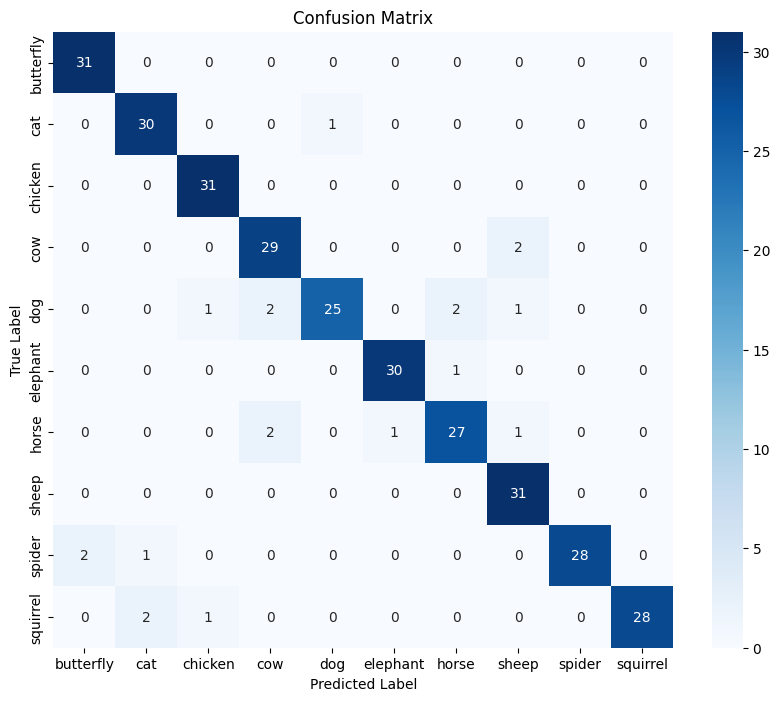

In [65]:
plot_confusion_matrix(conf_matrix, standardized_test_dataset)

**Random Forest** performed exceptionally well! With an **accuracy of 93.5%**, it demonstrates strong classification capabilities despite being a traditional machine learning model.  Training was **incredibly fast—only 1.7** seconds. 

The **confusion matrix** is **well-balanced** and **nearly diagonal**, meaning the model classifies most images correctly without major biases. Only minor misclassifications exist, primarily between visually similar animals (e.g., dogs, cats, and cows).

### 3.3 XGBoost Model

**XGBoost (Extreme Gradient Boosting)** is a powerful tree-based model that improves predictions using **gradient boosting**, an iterative approach that corrects previous errors.

*Trains XGBoost on ResNet-18 extracted features and records training time.*

**Step 1:** Train XGBoost on Extracted Features

In [70]:
# Define XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric="mlogloss", random_state=42)

# Train and measure time
start_time = time.time()
xgb_model.fit(train_features.reshape(train_features.shape[0], -1), train_labels)
training_time = time.time() - start_time

print(f"XGBoost Training Time: {training_time:.2f} seconds")

XGBoost Training Time: 4.67 seconds


**Step 2:** Evaluate XGBoost

*Evaluates XGBoost on test data and stores results.*

In [71]:
# Make Predictions
xgb_preds = xgb_model.predict(test_features.reshape(test_features.shape[0], -1))

# Compute Metrics
accuracy = accuracy_score(test_labels, xgb_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, xgb_preds, average="macro", zero_division=0)
conf_matrix = confusion_matrix(test_labels, xgb_preds)

# Store Results
xgb_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Training Time (s)": training_time
}

print("XGBoost Evaluation Metrics:")
print(xgb_metrics)

XGBoost Evaluation Metrics:
{'Accuracy': 0.9193548387096774, 'Precision': 0.9234516887450702, 'Recall': 0.9193548387096774, 'F1-Score': 0.9198869715122658, 'Training Time (s)': 4.672809839248657}


**XGBoost** performed slightly worse than **Random Forest**, with an accuracy of **91.9%** compared to **93.5%**. The **precision**, **recall**, and **F1-score** are also lower, indicating more misclassifications. Training time **increased significantly**.  **Possible Reason:** **XGBoost** relies heavily on **boosted decision trees**, which might not generalize as well as Random Forest on features extracted from images.

### 3.4 Simple CNN Model

**Step 1:** Define the Simple CNN Model

*A simple CNN with two convolutional layers, ReLU activation, and max pooling*

In [105]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.3)  # Prevent overfitting

        # Compute correct input size for fc1 dynamically
        self.flatten_size = 64 * (224 // 4) * (224 // 4)  # 56x56 after 2 poolings
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.dropout(x)  # Apply dropout
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)  # No softmax needed (handled by loss function)
        return x


**Step 2:** Initialize Model, Loss, and Optimizer

*Define the CNN, set up CrossEntropy loss and Adam optimizer for training.*

In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = len(standardized_train_dataset.classes)
cnn_model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

**Step 3:** Training Function with Train/Val Tracking

*Trains the CNN for 10 epochs while tracking train/val loss & accuracy.*

In [107]:
def train_cnn(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate model
        model.eval()
        with torch.no_grad():
            total_val_loss, correct_val, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        model.train()

    training_time = time.time() - start_time
    return training_time, train_losses, val_losses, train_accs, val_accs

# Train the CNN
training_time, train_losses, val_losses, train_accs, val_accs = train_cnn(cnn_model, standardized_train_loader, standardized_val_loader, criterion, optimizer, epochs=50)

Epoch [1/50] - Train Loss: 2.5693, Train Acc: 0.1317 | Val Loss: 2.2238, Val Acc: 0.1467
Epoch [2/50] - Train Loss: 2.2074, Train Acc: 0.1986 | Val Loss: 2.1649, Val Acc: 0.2400
Epoch [3/50] - Train Loss: 2.1489, Train Acc: 0.2338 | Val Loss: 2.1856, Val Acc: 0.2100
Epoch [4/50] - Train Loss: 2.1122, Train Acc: 0.2309 | Val Loss: 2.0617, Val Acc: 0.2733
Epoch [5/50] - Train Loss: 1.9712, Train Acc: 0.2871 | Val Loss: 1.8960, Val Acc: 0.2933
Epoch [6/50] - Train Loss: 1.8810, Train Acc: 0.3403 | Val Loss: 1.8293, Val Acc: 0.3400
Epoch [7/50] - Train Loss: 1.7644, Train Acc: 0.3647 | Val Loss: 1.8017, Val Acc: 0.3567
Epoch [8/50] - Train Loss: 1.7115, Train Acc: 0.3863 | Val Loss: 1.7820, Val Acc: 0.3567
Epoch [9/50] - Train Loss: 1.6045, Train Acc: 0.4216 | Val Loss: 1.7024, Val Acc: 0.4300
Epoch [10/50] - Train Loss: 1.5112, Train Acc: 0.4827 | Val Loss: 1.6169, Val Acc: 0.4533
Epoch [11/50] - Train Loss: 1.4346, Train Acc: 0.4827 | Val Loss: 1.6926, Val Acc: 0.4567
Epoch [12/50] - Tra

**Step 4:** Plot Accuracy & Loss Curves

*Visualizes training progress over epochs.*

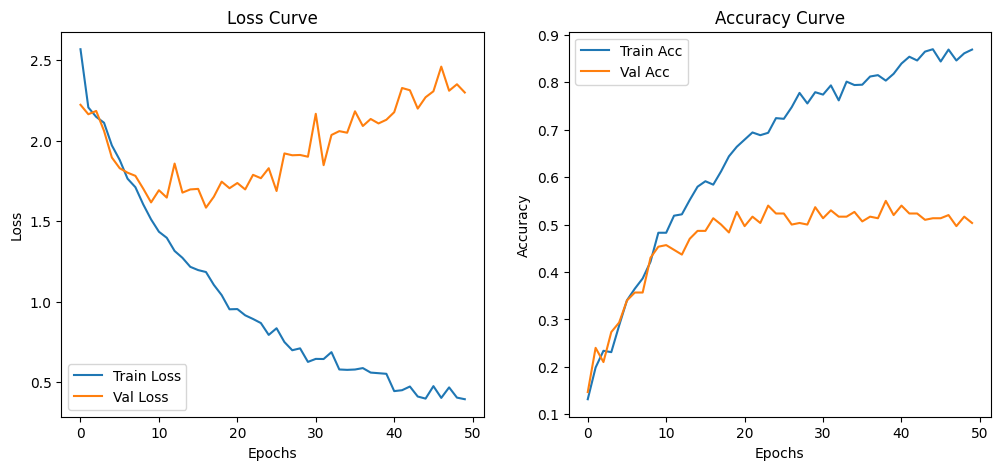

In [108]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss Curve
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Val Loss")
    axes[0].set_title("Loss Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy Curve
    axes[1].plot(train_accs, label="Train Acc")
    axes[1].plot(val_accs, label="Val Acc")
    axes[1].set_title("Accuracy Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.show()

plot_training_curves(train_losses, val_losses, train_accs, val_accs)

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss Curve
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Val Loss")
    axes[0].set_title("Loss Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy Curve
    axes[1].plot(train_accs, label="Train Acc")
    axes[1].plot(val_accs, label="Val Acc")
    axes[1].set_title("Accuracy Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.show()

In [154]:
import torch
import torch.nn as nn

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # First block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Second block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Third block
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 7 * 7, 1024),  # Adjust for input size after pooling
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = self.fc_layers(x)
        return x


In [155]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(standardized_train_dataset.classes)

cnn_model = AdvancedCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


c:\Users\davyd\miniconda3\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import copy
import time

def train_advanced_cnn(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=5):
    model.train()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()
    
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0

        # Training phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_val_loss, correct_val, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Learning Rate Scheduler Update
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check for best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            print("🔥 New Best Model Saved!")
        else:
            early_stop_counter += 1
            print(f"⏳ Early Stop Counter: {early_stop_counter}/{patience}")

        # Early Stopping
        if early_stop_counter >= patience:
            print("⏹ Early stopping triggered! Restoring best model.")
            model.load_state_dict(best_model_wts)
            break

    training_time = time.time() - start_time
    return training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts

# Train CNN with Early Stopping
training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts = train_advanced_cnn(
    cnn_model, standardized_train_loader, standardized_val_loader, criterion, optimizer, scheduler, epochs=100, patience=10
)

# Load best model weights
cnn_model.load_state_dict(best_model_wts)

Epoch [1/100] - Train Loss: 1.2989, Train Acc: 0.5489 | Val Loss: 1.2197, Val Acc: 0.5433
🔥 New Best Model Saved!
Epoch [2/100] - Train Loss: 1.2055, Train Acc: 0.5619 | Val Loss: 1.1863, Val Acc: 0.5800
🔥 New Best Model Saved!
Epoch [3/100] - Train Loss: 1.1757, Train Acc: 0.5806 | Val Loss: 1.7176, Val Acc: 0.4600
⏳ Early Stop Counter: 1/5
Epoch [4/100] - Train Loss: 1.1486, Train Acc: 0.5799 | Val Loss: 1.3228, Val Acc: 0.5500
⏳ Early Stop Counter: 2/5
Epoch [5/100] - Train Loss: 1.1220, Train Acc: 0.5942 | Val Loss: 1.3719, Val Acc: 0.5233
⏳ Early Stop Counter: 3/5
Epoch [6/100] - Train Loss: 1.1796, Train Acc: 0.5791 | Val Loss: 1.1537, Val Acc: 0.5767
🔥 New Best Model Saved!
Epoch [7/100] - Train Loss: 1.1113, Train Acc: 0.6050 | Val Loss: 2.0708, Val Acc: 0.4033
⏳ Early Stop Counter: 1/5
Epoch [8/100] - Train Loss: 1.0615, Train Acc: 0.6194 | Val Loss: 1.3649, Val Acc: 0.5567
⏳ Early Stop Counter: 2/5
Epoch [9/100] - Train Loss: 1.0132, Train Acc: 0.6345 | Val Loss: 1.6234, Val 

<All keys matched successfully>

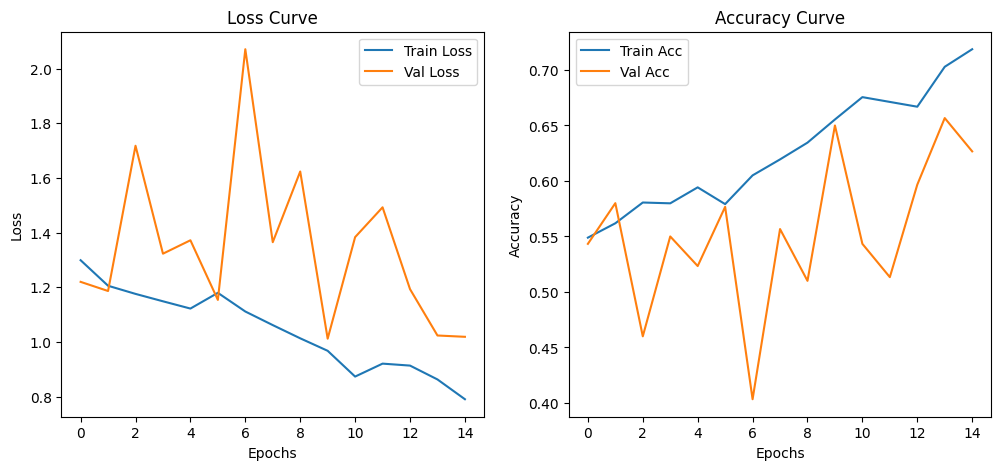

In [158]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

In [159]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Standardization without augmentation
cnn_train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standardization
])

cnn_val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets with new transformations
cnn_train_dataset = datasets.ImageFolder(root=train_path, transform=cnn_train_transforms)
cnn_val_dataset = datasets.ImageFolder(root=val_path, transform=cnn_val_test_transforms)
cnn_test_dataset = datasets.ImageFolder(root=test_path, transform=cnn_val_test_transforms)

# Define new dataloaders
BATCH_SIZE = 32
cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("✅ CNN Dataloaders Created Successfully!")


✅ CNN Dataloaders Created Successfully!


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Image size from Kaggle example
TARGET_SIZE = (256, 256)

# Standardization and augmentation (same as Kaggle)
cnn_train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

cnn_val_test_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
])

# Load datasets
cnn_train_dataset = datasets.ImageFolder(root=train_path, transform=cnn_train_transforms)
cnn_val_dataset = datasets.ImageFolder(root=val_path, transform=cnn_val_test_transforms)
cnn_test_dataset = datasets.ImageFolder(root=test_path, transform=cnn_val_test_transforms)

# Define new dataloaders
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL_TEST = 500  # Following Kaggle approach

cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=BATCH_SIZE_VAL_TEST, shuffle=False)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=BATCH_SIZE_VAL_TEST, shuffle=False)

print("✅ CNN Data Loaders Created (Following Kaggle Setup)")


✅ CNN Data Loaders Created (Following Kaggle Setup)


In [164]:
import torch
import torch.nn as nn

class CNN_Kaggle(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Kaggle, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


In [165]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(cnn_train_dataset.classes)

cnn_model = CNN_Kaggle(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Scheduler (Reduce LR if validation loss stops improving)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.1, min_lr=0.0000001)


In [168]:
import copy
import time

def train_kaggle_cnn(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, patience=4):
    model.train()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()
    
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        with torch.no_grad():
            total_val_loss, correct_val, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            print("🔥 New Best Model Saved!")
        else:
            early_stop_counter += 1
            print(f"⏳ Early Stop Counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print("⏹ Early stopping triggered! Restoring best model.")
            model.load_state_dict(best_model_wts)
            break

    training_time = time.time() - start_time
    return training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts

# Train CNN (Following Kaggle Approach)
training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts = train_kaggle_cnn(
    cnn_model, cnn_train_loader, cnn_val_loader, criterion, optimizer, scheduler, epochs=100, patience=50
)

# Load best model weights
cnn_model.load_state_dict(best_model_wts)


Epoch [1/100] - Train Loss: 1.2052, Train Acc: 0.5849 | Val Loss: 1.5212, Val Acc: 0.5067
🔥 New Best Model Saved!
Epoch [2/100] - Train Loss: 1.1193, Train Acc: 0.6079 | Val Loss: 1.2900, Val Acc: 0.5300
🔥 New Best Model Saved!
Epoch [3/100] - Train Loss: 1.0183, Train Acc: 0.6302 | Val Loss: 1.2733, Val Acc: 0.5400
🔥 New Best Model Saved!
Epoch [4/100] - Train Loss: 0.9857, Train Acc: 0.6540 | Val Loss: 1.2959, Val Acc: 0.5467
⏳ Early Stop Counter: 1/50
Epoch [5/100] - Train Loss: 0.9602, Train Acc: 0.6532 | Val Loss: 1.2868, Val Acc: 0.5600
⏳ Early Stop Counter: 2/50
Epoch [6/100] - Train Loss: 0.9580, Train Acc: 0.6439 | Val Loss: 1.2682, Val Acc: 0.5467
🔥 New Best Model Saved!
Epoch [7/100] - Train Loss: 0.9121, Train Acc: 0.6705 | Val Loss: 1.3143, Val Acc: 0.5533
⏳ Early Stop Counter: 1/50
Epoch [8/100] - Train Loss: 0.9055, Train Acc: 0.6835 | Val Loss: 1.2109, Val Acc: 0.5767
🔥 New Best Model Saved!
Epoch [9/100] - Train Loss: 0.9421, Train Acc: 0.6676 | Val Loss: 1.1914, Val A

KeyboardInterrupt: 

In [167]:
cnn_metrics, cnn_conf_matrix = evaluate_model(cnn_model, cnn_test_loader, cnn_test_dataset, device)
cnn_metrics["Training Time (s)"] = training_time

print("Kaggle CNN Evaluation Metrics:")
print(cnn_metrics)

Kaggle CNN Evaluation Metrics:
{'Accuracy': 0.5225806451612903, 'Precision': 0.5752221308820188, 'Recall': 0.5225806451612903, 'F1-Score': 0.5323133604186359, 'Training Time (s)': 287.87676334381104}


In [179]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = "data"  # Folder containing 10 animal class folders
split_path = "full_split_data"

# Create train, val, and test directories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(split_path, split), exist_ok=True)

split_ratio = {"train": 0.7, "val": 0.15, "test": 0.15}

for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    
    # Shuffle and split images
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratio["train"]), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=split_ratio["test"] / (split_ratio["val"] + split_ratio["test"]), random_state=42)
    
    # Copy images to respective folders
    for split, img_list in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_class_path = os.path.join(split_path, split, cls)
        os.makedirs(split_class_path, exist_ok=True)
        
        for img in img_list:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(split_class_path, img)
            shutil.copy(src_path, dst_path)

print("✅ Dataset successfully split into Train, Validation, and Test sets!")


✅ Dataset successfully split into Train, Validation, and Test sets!


In [180]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define paths
train_path = os.path.join(split_path, "train")
val_path = os.path.join(split_path, "val")
test_path = os.path.join(split_path, "test")

# Image size from Kaggle approach
TARGET_SIZE = (256, 256)

# Standardization & Augmentation (Kaggle approach)
cnn_train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

cnn_val_test_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
])

# Load datasets
cnn_train_dataset = datasets.ImageFolder(root=train_path, transform=cnn_train_transforms)
cnn_val_dataset = datasets.ImageFolder(root=val_path, transform=cnn_val_test_transforms)
cnn_test_dataset = datasets.ImageFolder(root=test_path, transform=cnn_val_test_transforms)

# Define new dataloaders (Following Kaggle)
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL_TEST = 500  

cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=BATCH_SIZE_VAL_TEST, shuffle=False)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=BATCH_SIZE_VAL_TEST, shuffle=False)

print("✅ CNN Data Loaders Created (Following Kaggle Setup)")


✅ CNN Data Loaders Created (Following Kaggle Setup)


In [181]:
import torch
import torch.nn as nn

class CNN_Kaggle(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Kaggle, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x

## BAZA BOMBAS

In [182]:
import torch.optim as optim
import copy
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(cnn_train_dataset.classes)

cnn_model = CNN_Kaggle(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.1, min_lr=0.0000001)

def train_kaggle_cnn(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, patience=4):
    model.train()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()
    
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        scheduler.step(train_loss)

    training_time = time.time() - start_time
    return training_time, train_losses, train_accs

# Train the model on the full dataset
training_time, train_losses, train_accs = train_kaggle_cnn(cnn_model, cnn_train_loader, cnn_val_loader, criterion, optimizer, scheduler, epochs=100, patience=4)

Epoch [1/100] - Train Loss: 2.5448, Train Acc: 0.1108
Epoch [2/100] - Train Loss: 2.2368, Train Acc: 0.1633
Epoch [3/100] - Train Loss: 2.1876, Train Acc: 0.1971


KeyboardInterrupt: 

### 3.6 Transfer Learning models

#### 3.6.1 EfficientNetB2 Model

Now, I will implement **EfficientNet-B2**, a state-of-the-art **CNN** architecture optimized for accuracy and efficiency.

Unlike custom **CNN**, **EfficientNet-B2** is pre-trained on **ImageNet**, meaning it already understands image features like edges, textures, and shapes. We will fine-tune the last layers for our specific classification task.

**Step 1:** Load Pre-Trained EfficientNet-B2

*Uses a pre-trained EfficientNet and replaces the final classification layer to match 10 classes.*

In [112]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load EfficientNet-B2 Pretrained Model
efficientnet_b2 = models.efficientnet_b2(pretrained=True)

# Modify the final classification layer
num_classes = len(transfer_train_dataset.classes)
efficientnet_b2.classifier[1] = nn.Linear(efficientnet_b2.classifier[1].in_features, num_classes)

# Move model to GPU if available
efficientnet_b2 = efficientnet_b2.to(device)

**Step 2:** Define Loss and Optimizer

*Uses CrossEntropyLoss for multi-class classification and Adam optimizer for efficient training.*

In [113]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_b2.parameters(), lr=0.0001)

**Step 3:** Fine-Tuning the Model

*Fine-tunes EfficientNet-B2 on the dataset while tracking loss & accuracy.*

In [114]:
def train_transfer_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate model
        model.eval()
        with torch.no_grad():
            total_val_loss, correct_val, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        model.train()

    training_time = time.time() - start_time
    return training_time, train_losses, val_losses, train_accs, val_accs

# Train EfficientNet-B2
training_time, train_losses, val_losses, train_accs, val_accs = train_transfer_model(efficientnet_b2, transfer_train_loader, transfer_val_loader, criterion, optimizer, epochs=10)

Epoch [1/10] - Train Loss: 1.7012, Train Acc: 0.6194 | Val Loss: 0.8963, Val Acc: 0.9233
Epoch [2/10] - Train Loss: 0.5561, Train Acc: 0.9482 | Val Loss: 0.2976, Val Acc: 0.9667
Epoch [3/10] - Train Loss: 0.2159, Train Acc: 0.9647 | Val Loss: 0.1843, Val Acc: 0.9767
Epoch [4/10] - Train Loss: 0.0956, Train Acc: 0.9906 | Val Loss: 0.1566, Val Acc: 0.9667
Epoch [5/10] - Train Loss: 0.0577, Train Acc: 0.9935 | Val Loss: 0.1441, Val Acc: 0.9700
Epoch [6/10] - Train Loss: 0.0609, Train Acc: 0.9935 | Val Loss: 0.1191, Val Acc: 0.9767
Epoch [7/10] - Train Loss: 0.0321, Train Acc: 0.9957 | Val Loss: 0.1341, Val Acc: 0.9633
Epoch [8/10] - Train Loss: 0.0253, Train Acc: 0.9971 | Val Loss: 0.1327, Val Acc: 0.9633
Epoch [9/10] - Train Loss: 0.0190, Train Acc: 0.9986 | Val Loss: 0.1152, Val Acc: 0.9733
Epoch [10/10] - Train Loss: 0.0212, Train Acc: 0.9971 | Val Loss: 0.1208, Val Acc: 0.9700


**Step 4:** Plot Accuracy & Loss Curves

*Visualizes how accuracy and loss change during training.*

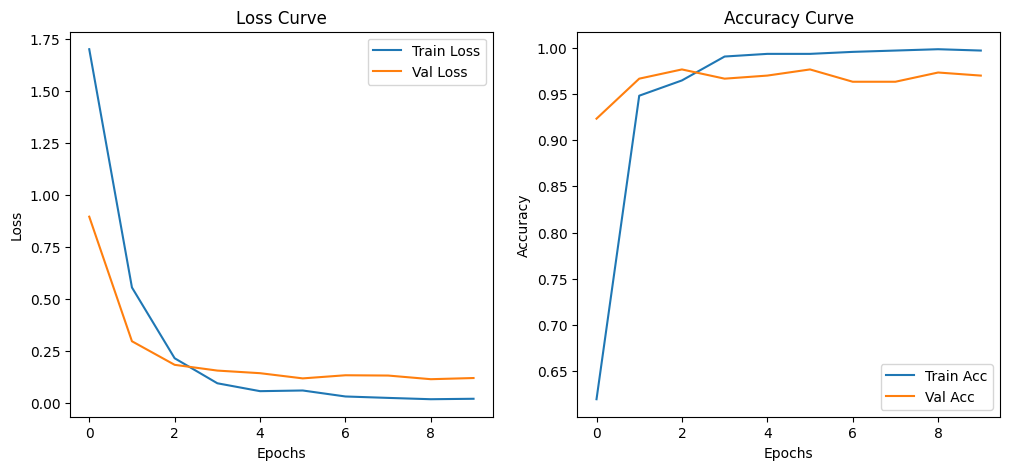

In [ ]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

After 3 epochs, **EfficientNet-B2** achieved an **accuracy of 97.5%** on the validation set and stoped improving validation accuracy. So for future models, I will use **early stopping** to prevent overfitting.

**Step 5:** Evaluate EfficientNet-B2 Performance

*Computes accuracy, precision, recall, and F1-score for EfficientNet-B2.*

In [116]:
effnet_metrics, effnet_conf_matrix = evaluate_model(efficientnet_b2, transfer_test_loader, transfer_test_dataset, device)

# Add training time
effnet_metrics["Training Time (s)"] = training_time

print("EfficientNet-B2 Evaluation Metrics:")
print(effnet_metrics)

EfficientNet-B2 Evaluation Metrics:
{'Accuracy': 0.9741935483870968, 'Precision': 0.9741451149425288, 'Recall': 0.9741935483870968, 'F1-Score': 0.9739708561020036, 'Training Time (s)': 105.8400604724884}


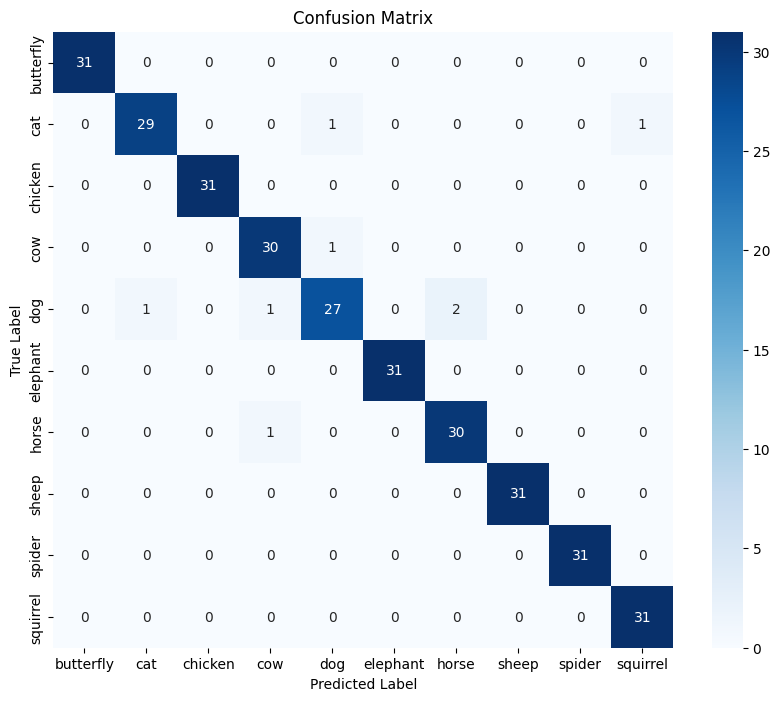

In [117]:
plot_confusion_matrix(effnet_conf_matrix, transfer_test_dataset)

On the test set **EfficientNet-B2** achieved an **accuracy of 97.5%**.  Precision, recall, and F1-score are also high, indicating that the model **accurately classifies** most images. The **confusion matrix** is **nearly diagonal**, indicating few misclassifications.

#### 3.6.2 ResNet-50 Model

ResNet-50 is a popular CNN architecture known for its **residual connections**, which help prevent **vanishing gradients** and **improve training**. 

In order not to repeat previous mistakes, I made during training **EfficientNet-B2**, I will **improve the ResNet-50 training by:**
- **Early stopping** → Stop training if validation loss stops improving to avoid overfitting.
- **Model checkpointing** → Save the best model during training for later use.

Additionally I will **unfreeze some layers → allow the model to fine-tune deeper layers for better feature extraction**.

**Step 1:** Load Pre-Trained ResNet-50

*Loads pre-trained ResNet-50 and replaces the fully connected layer to match dataset (10 classes)*

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ResNet-50 Pretrained Model
resnet50 = models.resnet50(pretrained=True)

# Unfreeze the last few layers for fine-tuning
for param in list(resnet50.parameters())[:-10]:  # Freeze all layers except the last 10
    param.requires_grad = False

# Modify the final classification layer
num_classes = len(transfer_train_dataset.classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Move model to GPU if available
resnet50 = resnet50.to(device)

**Step 2:** Define Loss and Optimizer

*Uses CrossEntropyLoss for multi-class classification and Adam optimizer for efficient training.*

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

**Step 3:** Fine-Tuning the Model

*Fine-tunes ResNet-50 on our dataset while tracking loss & accuracy.*

In [ ]:
def train_transfer_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=5):
    model.train()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()
    
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0

        # Training phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_val_loss, correct_val, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Learning Rate Scheduler Update
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check for best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            print("🔥 New Best Model Saved!")
        else:
            early_stop_counter += 1
            print(f"⏳ Early Stop Counter: {early_stop_counter}/{patience}")

        # Early Stopping
        if early_stop_counter >= patience:
            print("⏹ Early stopping triggered! Restoring best model.")
            model.load_state_dict(best_model_wts)
            break

    training_time = time.time() - start_time
    return training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts

# Train ResNet-50 
training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts = train_transfer_model(
    resnet50, transfer_train_loader, transfer_val_loader, criterion, optimizer, scheduler, epochs=20, patience=5
)

# Load best model weights
resnet50.load_state_dict(best_model_wts)


Epoch [1/20] - Train Loss: 1.0279, Train Acc: 0.8151 | Val Loss: 0.2806, Val Acc: 0.9667
🔥 New Best Model Saved!
Epoch [2/20] - Train Loss: 0.2037, Train Acc: 0.9712 | Val Loss: 0.1850, Val Acc: 0.9700
🔥 New Best Model Saved!
Epoch [3/20] - Train Loss: 0.1057, Train Acc: 0.9928 | Val Loss: 0.1454, Val Acc: 0.9733
🔥 New Best Model Saved!
Epoch [4/20] - Train Loss: 0.0634, Train Acc: 0.9964 | Val Loss: 0.1363, Val Acc: 0.9667
🔥 New Best Model Saved!
Epoch [5/20] - Train Loss: 0.0457, Train Acc: 0.9957 | Val Loss: 0.1301, Val Acc: 0.9733
🔥 New Best Model Saved!
Epoch [6/20] - Train Loss: 0.0436, Train Acc: 0.9964 | Val Loss: 0.1202, Val Acc: 0.9667
🔥 New Best Model Saved!
Epoch [7/20] - Train Loss: 0.0290, Train Acc: 0.9986 | Val Loss: 0.1176, Val Acc: 0.9700
🔥 New Best Model Saved!
Epoch [8/20] - Train Loss: 0.0248, Train Acc: 0.9993 | Val Loss: 0.1138, Val Acc: 0.9700
🔥 New Best Model Saved!
Epoch [9/20] - Train Loss: 0.0189, Train Acc: 1.0000 | Val Loss: 0.1091, Val Acc: 0.9700
🔥 New B

<All keys matched successfully>

**Step 4:** Plot Accuracy & Loss Curves

*Visualizes how accuracy and loss change during training.*

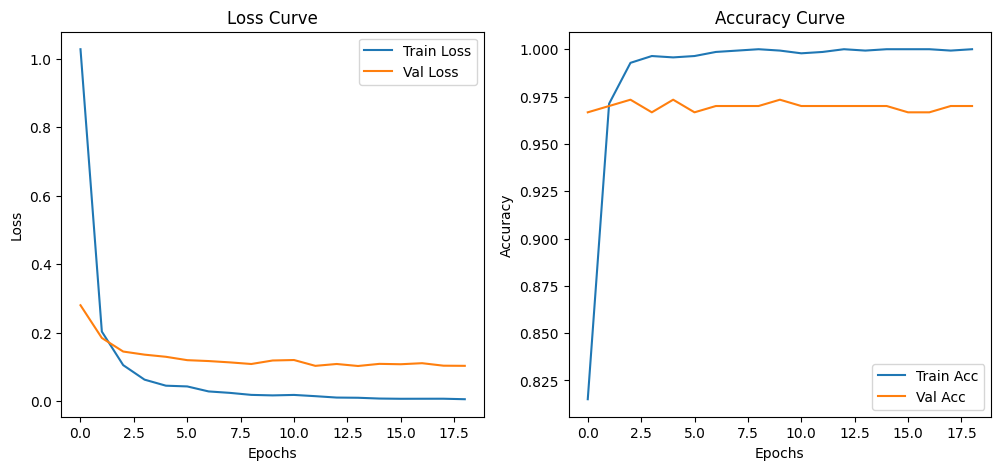

In [127]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

As I set for early stopping, so large number of counts for stopping(5), model stopped on the second to last epoch, with **accuracy of 97%** on the validation set.

**Step 5:** Evaluate ResNet-50 Performance

*Computes accuracy, precision, recall, and F1-score for ResNet-50.*

In [128]:
resnet_metrics, resnet_conf_matrix = evaluate_model(resnet50, transfer_test_loader, transfer_test_dataset, device)

# Add training time
resnet_metrics["Training Time (s)"] = training_time

print("ResNet-50 Evaluation Metrics:")
print(resnet_metrics)

ResNet-50 Evaluation Metrics:
{'Accuracy': 0.9709677419354839, 'Precision': 0.9713257575757577, 'Recall': 0.970967741935484, 'F1-Score': 0.9709032656778558, 'Training Time (s)': 136.02926087379456}


*Displays confusion matrix for ResNet-50*

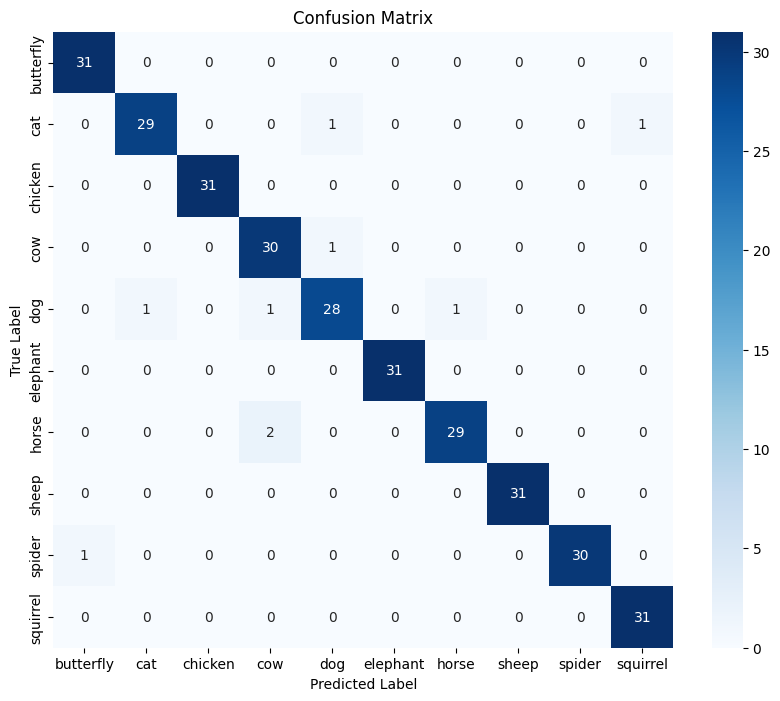

In [129]:
plot_confusion_matrix(resnet_conf_matrix, transfer_test_dataset)

ResNet-50 showed few lower results than EfficientNet-B2, with an **accuracy of 97%** on the test set. Precision, recall, and F1-score are also slightly lower, indicating more misclassifications. 

Confusion matrix for ResNet-50 are very similar to EfficientNet-B2, with the same positions of misclassifications. It means that there are some images that are very hard to classify and later I will analyze them. But before that I will try other models.

#### 3.6.3 MobileNetV3-Small

Now, I will train **MobileNetV3-Small**. It is smaller and faster than ResNet or EfficientNet but still provides good accuracy.

Like before, I will:
- **Unfreeze some layers**(unfreeze the last 5 layers)
- **Use early stopping**(decrease patience to 3)
- **Save the best model** 

**Step 1:** Load Pre-Trained MobileNetV3-Small

Unfreezes in that case last 5 layers and replaces the classifier for 10-class dataset.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load MobileNetV3-Small Pretrained Model
mobilenet_v3 = models.mobilenet_v3_small(pretrained=True)

# Unfreeze last few layers for fine-tuning
for param in list(mobilenet_v3.parameters())[:-5]:  # Keep first layers frozen
    param.requires_grad = False

# Modify the final classification layer
num_classes = len(transfer_train_dataset.classes)
mobilenet_v3.classifier[3] = nn.Linear(mobilenet_v3.classifier[3].in_features, num_classes)

# Move model to GPU if available
mobilenet_v3 = mobilenet_v3.to(device)

**Step 2:** Define Loss, Optimizer & Scheduler

*Uses CrossEntropyLoss and Adam optimizer, with learning rate scheduling to adjust training dynamically.*

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v3.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

**Step 3:** Implement Early Stopping & Checkpointing

In [144]:
def train_transfer_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=5):
    model.train()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    start_time = time.time()
    
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0

        # Training phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_val_loss, correct_val, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Learning Rate Scheduler Update
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check for best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            print("🔥 New Best Model Saved!")
        else:
            early_stop_counter += 1
            print(f"⏳ Early Stop Counter: {early_stop_counter}/{patience}")

        # Early Stopping
        if early_stop_counter >= patience:
            print("⏹ Early stopping triggered! Restoring best model.")
            model.load_state_dict(best_model_wts)
            break

    training_time = time.time() - start_time
    return training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts

# Train MobileNetV3-Small with Early Stopping
training_time, train_losses, val_losses, train_accs, val_accs, best_model_wts = train_transfer_model(
    mobilenet_v3, transfer_train_loader, transfer_val_loader, criterion, optimizer, scheduler, epochs=20, patience=3
)

# Load best model weights
mobilenet_v3.load_state_dict(best_model_wts)

Epoch [1/20] - Train Loss: 1.8422, Train Acc: 0.4827 | Val Loss: 1.4235, Val Acc: 0.6900
🔥 New Best Model Saved!
Epoch [2/20] - Train Loss: 1.2387, Train Acc: 0.7669 | Val Loss: 0.9999, Val Acc: 0.8167
🔥 New Best Model Saved!
Epoch [3/20] - Train Loss: 0.8664, Train Acc: 0.8482 | Val Loss: 0.8011, Val Acc: 0.8500
🔥 New Best Model Saved!
Epoch [4/20] - Train Loss: 0.6658, Train Acc: 0.8727 | Val Loss: 0.6836, Val Acc: 0.8500
🔥 New Best Model Saved!
Epoch [5/20] - Train Loss: 0.5501, Train Acc: 0.8856 | Val Loss: 0.5913, Val Acc: 0.8567
🔥 New Best Model Saved!
Epoch [6/20] - Train Loss: 0.4547, Train Acc: 0.9036 | Val Loss: 0.5113, Val Acc: 0.8933
🔥 New Best Model Saved!
Epoch [7/20] - Train Loss: 0.4187, Train Acc: 0.9036 | Val Loss: 0.4474, Val Acc: 0.9033
🔥 New Best Model Saved!
Epoch [8/20] - Train Loss: 0.3596, Train Acc: 0.9216 | Val Loss: 0.4069, Val Acc: 0.9067
🔥 New Best Model Saved!
Epoch [9/20] - Train Loss: 0.3375, Train Acc: 0.9137 | Val Loss: 0.3767, Val Acc: 0.8933
🔥 New B

<All keys matched successfully>

The model did not stop learning and studied all 20 epochs.  

**Step 4:** Plot Accuracy & Loss Curves

*Visualizes training progress.*

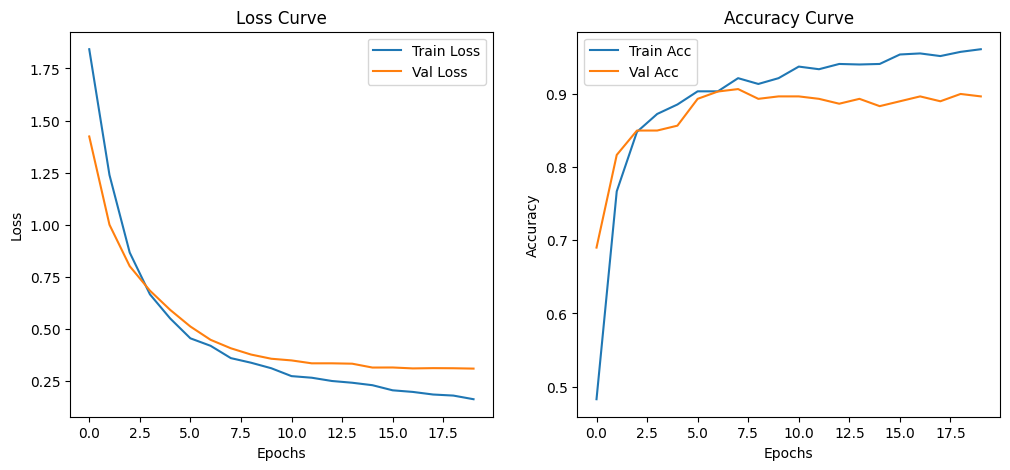

In [145]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

The training curves closely resemble those of previous models, with a slight drop in accuracy towards the end of training. The model struggled to extract key features from the images, resulting in stagnant validation accuracy throughout training.

**Step 5:** Evaluate MobileNetV3-Small Performance

*Computes accuracy, precision, recall, and F1-score for MobileNetV3-Small.*

In [146]:
mobilenet_metrics, mobilenet_conf_matrix = evaluate_model(mobilenet_v3, transfer_test_loader, transfer_test_dataset, device)

# Add training time
mobilenet_metrics["Training Time (s)"] = training_time

print("MobileNetV3-Small Evaluation Metrics:")
print(mobilenet_metrics)

MobileNetV3-Small Evaluation Metrics:
{'Accuracy': 0.9129032258064517, 'Precision': 0.9175651917658559, 'Recall': 0.9129032258064516, 'F1-Score': 0.9136413690288328, 'Training Time (s)': 119.07905864715576}


Model showed very similar results to XGBoost, with an **accuracy of 91.5%** on the test set. Precision, recall, and F1-score are also lower, indicating more misclassifications.

Finally let's move to the next section to compare all models and analyze the results.

## 4. Model Evaluation & Interpretation

### 4.1 Comparing Model Performance

### 4.2 Analyzing Misclassifications

Since **EfficientNet-B2** achieved the best results, I will analyze its misclassifications to understand where it fails and why.

**What I Do:**
- Identify misclassified images from the test set.
- Display them in a grid plot (4x2).
- Use green text for the true label and red text for the predicted label.
- Show model confidence in prediction (probability of predicted class).

**Why EfficientNet-B2?**

It showed the best accuracy, so analyzing its mistakes will give us the most useful insights about dataset complexity.


**Step 1:** Identify Misclassified Images

In [ ]:
def get_misclassified_images(model, dataloader, dataset, device, num_images=8):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1) 
            confidences, preds = torch.max(probs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:  # If misclassified
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu(), confidences[i].cpu().item()))
                if len(misclassified) >= num_images:
                    return misclassified
    return misclassified

# Get 8 misclassified images
misclassified_samples = get_misclassified_images(efficientnet_b2, transfer_test_loader, transfer_test_dataset, device, num_images=8)

**Step 2:** Visualize Misclassifications

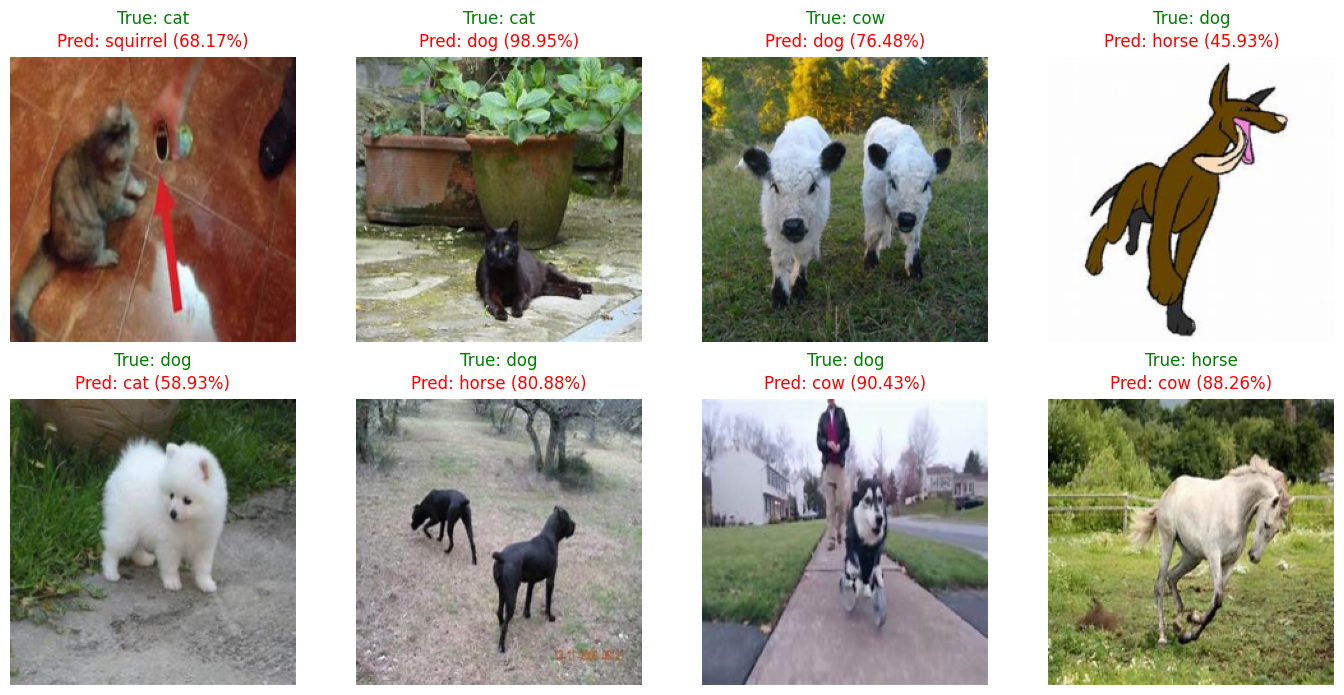

In [ ]:
def plot_misclassified_images(misclassified_samples, class_names):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    plt.subplots_adjust(top=0.85)  # Adjust top margin for titles

    for i, (image, true_label, pred_label, confidence) in enumerate(misclassified_samples):
        ax = axes[i // 4, i % 4]
        image = image.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())
        
        ax.imshow(image)
        ax.axis("off")

        true_class = class_names[true_label]
        predicted_class = class_names[pred_label]

        # Add titles with custom positioning and colors
        ax.text(0.5, 1.1, f"True: {true_class}", 
                color='green', fontsize=12, ha='center', va='bottom', 
                transform=ax.transAxes)
        
        ax.text(0.5, 1.02, f"Pred: {predicted_class} ({confidence:.2%})", 
                color='red', fontsize=12, ha='center', va='bottom', 
                transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

# Get class names
class_names = transfer_test_dataset.classes

# Plot misclassified images with correct title formatting
plot_misclassified_images(misclassified_samples, class_names)


Some misclassified images are **genuinely confusing**, making it difficult even for humans to predict correctly. However, there are also cases where the **true class is obvious**, yet the model makes a **high-confidence incorrect prediction**.

Overall, most errors come from hard-to-classify images, proving that the **built model is strong** and struggles mainly with edge cases.

For **deeper analysis**, let’s use **Grad-CAM** to understand **what the model focuses on** when making predictions.

### 4.3 Grad-CAM: Model Interpretation

Now, I will use **Grad-CAM** to understand why **EfficientNet-B2 makes mistakes** and what features it focuses on during predictions.

**What I Do:**
1. **Apply Grad-CAM to misclassified images** → See what the model focused on.
2. **Create a function for predicting new images** → Can take random images from a folder or a user-provided image path.
3. **Display predictions with confidence scores** → Helps evaluate model reliability.

**Step 1:** Implement Grad-CAM on Misclassified Images

This class allows to apply Grad-CAM to any CNN-based model, including EfficientNet-B2.

In [201]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.forward_hook = target_layer.register_forward_hook(self.save_activations)
        self.backward_hook = target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_heatmap(self, image, class_idx):
        # Forward pass through full model
        output = self.model(image.unsqueeze(0))
        self.model.zero_grad()
        
        # Backward pass for target class
        output[0, class_idx].backward()
        
        # Use registered activations and gradients
        gradients = self.gradients.cpu().numpy()
        activations = self.activations.cpu().numpy()
        
        # Pool gradients and weight activations
        weights = np.mean(gradients, axis=(2, 3))
        heatmap = np.zeros(activations.shape[2:], dtype=np.float32)
        
        for i, w in enumerate(weights[0]):
            heatmap += w * activations[0, i]
            
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)  # Normalize
        return heatmap

    def __del__(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

**Step 2:** Apply Grad-CAM on Misclassified Images

This function:
- Applies Grad-CAM to misclassified images
- Overlays heatmaps on the original image
- Displays where the model focused during prediction

In [207]:
def apply_heatmap(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to match image size
    heatmap = np.uint8(255 * heatmap)  
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) 

    # Ensure image is uint8 before blending
    image = (image * 255).astype(np.uint8)  

    # Blend original image with heatmap
    superimposed = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    return superimposed

def visualize_gradcam_grid(model, misclassified_samples, target_layer, class_names):
    num_images = len(misclassified_samples[:8])  # We visualize 8 images (each with its Grad-CAM)
    
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    plt.subplots_adjust(hspace=0.5)  # Add spacing between rows

    axes = axes.flatten()  # Flatten the 2D array of axes to 1D

    for idx, (image, true_label, pred_label, confidence) in enumerate(misclassified_samples[:8]):  
        # Process image for Grad-CAM
        image_tensor = image.to(device)
        grad_cam = GradCAM(model, target_layer)
        heatmap = grad_cam.generate_heatmap(image_tensor, pred_label)

        # Convert images to numpy
        image_np = image.cpu().permute(1, 2, 0).numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize
        heatmap_img = apply_heatmap(image_np, heatmap)

        # Flattened indexing for 4x4 grid
        ax_pred = axes[idx * 2]  # First: Prediction Image
        ax_cam = axes[idx * 2 + 1]  # Second: Grad-CAM

        # Plot Prediction Image
        ax_pred.imshow(image_np)
        ax_pred.axis("off")
        
        # Add title with colors for True (Green) and Pred (Red)
        ax_pred.text(0.5, 1.1, f"True: {class_names[true_label]}", 
                     color='green', fontsize=12, ha='center', va='bottom', 
                     transform=ax_pred.transAxes)

        ax_pred.text(0.5, 1.02, f"Pred: {class_names[pred_label]} ({confidence:.2%})", 
                     color='red', fontsize=12, ha='center', va='bottom', 
                     transform=ax_pred.transAxes)

        # Plot Grad-CAM Heatmap
        ax_cam.imshow(heatmap_img)
        ax_cam.axis("off")
        ax_cam.set_title("Grad-CAM", fontsize=12)

    plt.tight_layout()
    plt.show()

**Step 3:** Run Grad-CAM on Misclassified Images

This step display Grad-CAM heatmaps for misclassified images.

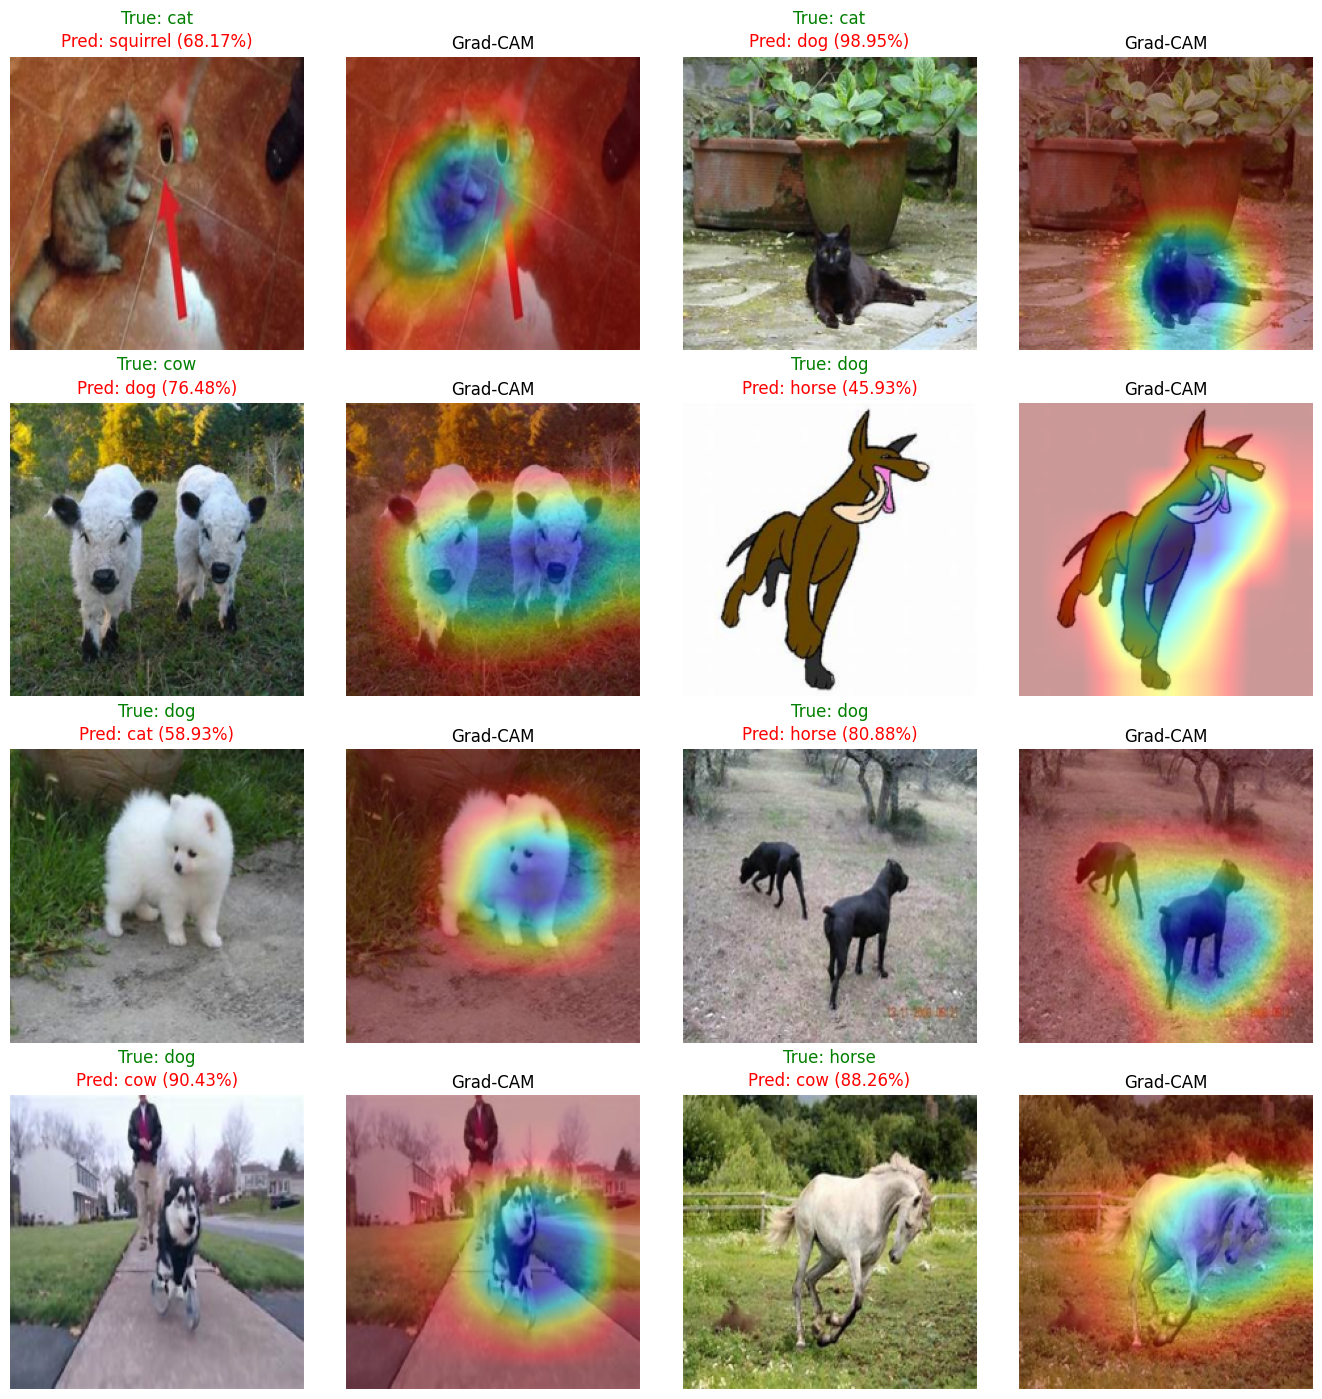

In [208]:
# ✅ Correct Target Layer Selection for EfficientNet-B2
target_layer = efficientnet_b2.features[-2]  # Last convolutional layer

# Run Grad-CAM on misclassified images in grid format
visualize_gradcam_grid(efficientnet_b2, misclassified_samples, target_layer, class_names)

**Step 4:** Function to Predict Images from Folder or User Input

In [215]:
def predict_image_with_gradcam(model, path, class_names, target_layer):
    model.eval()

    # Define transformation (same as training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Select image: from folder or direct file
    if os.path.isdir(path):  
        image_files = []
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith(('.jpg', '.png', '.jpeg')):  
                    image_files.append(os.path.join(root, file))

        if len(image_files) == 0:
            print("No images found in folder.")
            return
        
        image_path = random.choice(image_files)
    else:  # If path is a direct file
        if not os.path.isfile(path):
            print("File not found.")
            return
        image_path = path

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probs, 1)

    predicted_label = class_names[pred_idx.item()]

    # Convert image for Grad-CAM processing
    image_np = np.array(image)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  

    # Apply Grad-CAM
    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam.generate_heatmap(image_tensor.squeeze(0), pred_idx.item())
    heatmap_img = apply_heatmap(image_np, heatmap)

    # Plot prediction & Grad-CAM side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title(f"Predicted: {predicted_label} ({confidence.item():.2%})", color="red")

    # Grad-CAM Visualization
    axes[1].imshow(heatmap_img)
    axes[1].axis("off")
    axes[1].set_title("Grad-CAM")

    plt.show()

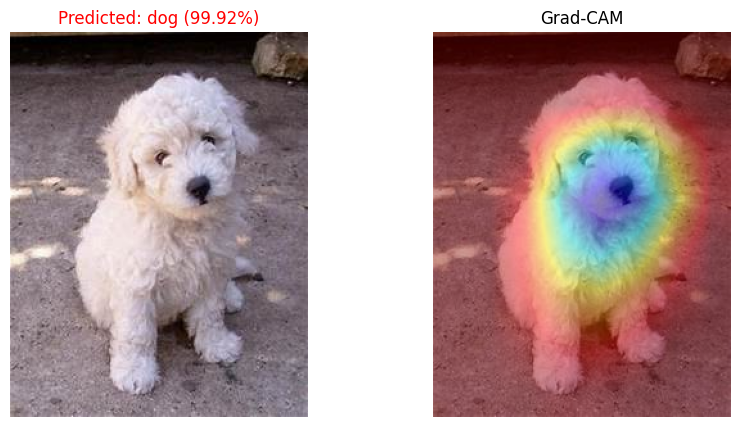

In [217]:
# Correct Target Layer Selection for EfficientNet-B2
target_layer = efficientnet_b2.features[-2] 

# Predict a random image from a folder and visualize Grad-CAM
predict_image_with_gradcam(efficientnet_b2, "data", class_names, target_layer)

**Grad-CAM works well**, highlighting key **features the model focuses on** during classification. **It correctly identifies relevant areas**, like faces or distinctive textures, confirming that the model makes **logical decisions**.

## 5. Model Deployment & Inference

### 5.1 Save and Load the Best Model

**Step 1:** Save the Best Model

In [ ]:
# Define model save path
model_save_path = "best_efficientnet_b2.pth"

# Save the model
torch.save({
    'model_state_dict': efficientnet_b2.state_dict(),
    'class_names': class_names 
}, model_save_path)

print(f"Model saved successfully at {model_save_path}")

Model saved successfully at best_efficientnet_b2.pth


**Step 2:** Load the Saved Model

In [219]:
# Reload model
def load_model(model_path, model_architecture, device):
    checkpoint = torch.load(model_path, map_location=device)

    # Load model architecture
    model = model_architecture.to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode

    # Load class names
    loaded_class_names = checkpoint.get('class_names', None)

    print("Model loaded successfully!")
    return model, loaded_class_names

# Example usage:
loaded_model, loaded_class_names = load_model(model_save_path, efficientnet_b2, device)

Model loaded successfully!


**Step 3:** Define the Target Layer for Grad-CAM

EfficientNet-B2’s **last convolutional layer** is needed for Grad-CAM

In [ ]:
# Define target layer for Grad-CAM 
target_layer = loaded_model.features[-2] 

### 5.2 Predicting on New Images

Now, use the loaded model, class names, and target layer I will predict on new images. For that I will use the function `predict_image_with_gradcam` from *4.3(step 4)*

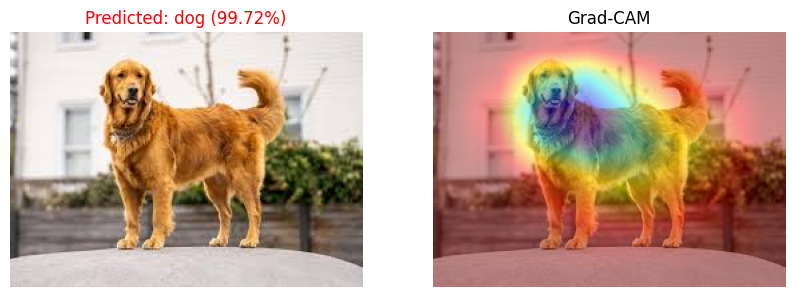

In [221]:
# Example usage: Predict a random image from the test folder
predict_image_with_gradcam(loaded_model, "test_images", loaded_class_names, target_layer)

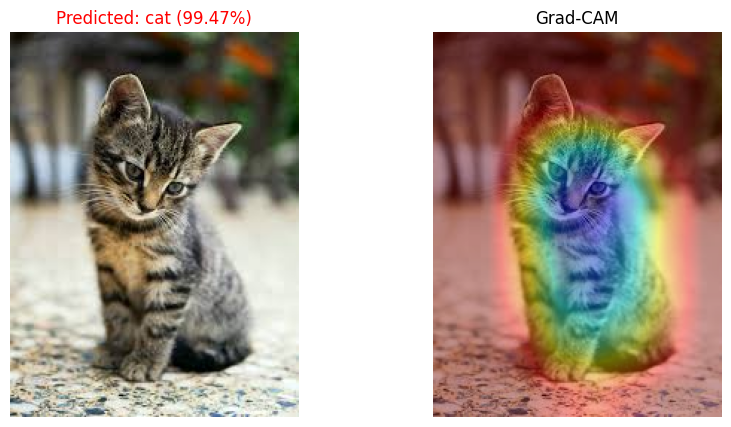

In [223]:
# Predict a specific image
predict_image_with_gradcam(loaded_model, "test_images/cat.jpg", loaded_class_names, target_layer)

## 6. Conclusion